In [16]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from src.utils.model_utils import evaulate_model, train_model
from src.utils.math_utils import get_fft_power, remove_gravity
from scipy.signal import butter, filtfilt, find_peaks, welch
from src.utils.visualize_utils import plot_cm, get_avg_fold
from scipy.spatial.transform import Rotation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
import random
import joblib
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Clean DataFrame
def get_counts(df) -> pd.DataFrame:
    return df.groupby("sequence_id")["sequence_counter"].max() - df.groupby("sequence_id")["sequence_counter"].min() + 1


def log_dropped(len_before, len_after, description):
    dropped = len_before - len_after
    perc_dropped = (dropped / len_before) * 100
    print(f"[{description}] Remaining: {len_after}/{len_before} " f"(-{dropped}, {perc_dropped:.1f}% dropped)")


def normalize_sequence_count(df: pd.DataFrame, group_col: str = "sequence_id", seq_counter_col: str = "sequence_counter") -> pd.DataFrame:
    """
    Adds gesture_counter_length with a value of the length of the elmeents of teh array
    it gets maximum + 1, so it is the execlusive end
    """
    out_groups = []
    max_count = get_counts(df).max()

    for _, group in df.groupby(group_col, sort=False):
        g = group.copy()
        # compute length for this group
        group_count = g[seq_counter_col].max() - g[seq_counter_col].min() + 1
        needed = max_count - group_count

        # Those had no impact on the results, will look at them later
        # broadcast the group length to existing rows
        # g["gesture_counter_length"] = group_count
        # g["is_original"] = 1

        if needed > 0:
            last = g.iloc[-1].copy()
            repeats = pd.DataFrame([last] * needed)

            # continue the sequence_counter for appended rows
            start = int(last[seq_counter_col])
            repeats[seq_counter_col] = range(start + 1, start + 1 + needed)

            # ensure the appended rows also carry the same group length
            # repeats["gesture_counter_length"] = group_count
            # repeats["is_original"] = 0

            g = pd.concat([g, repeats], ignore_index=True)

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)


def clean_df(df: pd.DataFrame, drop_rot_na=True, drop_thm_na=True, min_gesture_count=28, max_gesture_count=35):
    """
    min_gesture_count = 28, max_gesture_count = 35 was the current best performing
    put as -1 to not do it
    """
    df = df.copy()
    non_target_gestures = df[df["sequence_type"] == "Non-Target"]["gesture"].unique()
    target_gestures = df[df["sequence_type"] == "Target"]["gesture"].unique()

    filtered_df = df[df["phase"] == "Gesture"]
    filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

    curr_len = len(filtered_df)
    if drop_rot_na:
        # drop na rotation
        bad_seq_id = df[df["rot_w"].isnull()]["sequence_id"].unique()
        bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
        filtered_df = filtered_df[~bad_seq_mask]
        
        log_dropped(curr_len, len(filtered_df), "rot_na")
        curr_len = len(filtered_df)

    if drop_thm_na:
        for i in range(1, 6):
            bad_seq_id = df[df[f"thm_{i}"].isnull()]["sequence_id"].unique()
            bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
            filtered_df = filtered_df[~bad_seq_mask]


        log_dropped(curr_len, len(filtered_df), "thm_na")
        curr_len = len(filtered_df)

    # drop outliers in terms of count
    if min_gesture_count != -1 and max_gesture_count != -1:
        gesture_counts = get_counts(filtered_df)
        valid_mask = (gesture_counts >= min_gesture_count) & (gesture_counts <= max_gesture_count)
        valid_idx = gesture_counts[valid_mask].index
        filtered_df = filtered_df[filtered_df["sequence_id"].isin(valid_idx)]


        log_dropped(curr_len, len(filtered_df), "gesture_len outliers")
        curr_len = len(filtered_df)

    return filtered_df, target_gestures


In [18]:
# Feature Engineer
def rotation_feature_engineer(df: pd.DataFrame):
    df = df.copy()
    quat_arr = df[["rot_w", "rot_x", "rot_y", "rot_z"]].values
    num_samples = quat_arr.shape[0]
    angular_vel = np.zeros([num_samples, 3])
    
    rotation_object = Rotation.from_quat(quat_arr)
    rotation_vectors = rotation_object.as_rotvec()

    df["rotvec_x"] = rotation_vectors[:, 0]
    df["rotvec_y"] = rotation_vectors[:, 1]
    df["rotvec_z"] = rotation_vectors[:, 2]
    df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

    for i in range(num_samples - 1):
        try:
            rot_t = Rotation.from_quat(quat_arr[i])
            rot_next = Rotation.from_quat(quat_arr[i + 1])

            delta_rot = rot_t.inv() * rot_next
            
            angular_vel[i, :] = delta_rot.as_rotvec() / (1/200)
        except ValueError:
            continue
    
    df['angular_vel_x'] = angular_vel[:, 0]
    df['angular_vel_y'] = angular_vel[:, 1]
    df['angular_vel_z'] = angular_vel[:, 2]
    df['angular_speed'] = np.linalg.norm(angular_vel, axis=1)
    
    return df

def accelrometer_feature_engineer(df: pd.DataFrame):
    cols_of_interest = ["acc_x", "acc_y", "acc_z"]

    for col in cols_of_interest:
        df[f"fft_{col}"] = df.groupby("sequence_id")[col].transform(get_fft_power)

    df["acc_mag"] = np.linalg.norm([df["acc_x"], df["acc_y"], df["acc_z"]], axis=0)
    df["jerk_acc_x"] = df.groupby("sequence_id")["acc_x"].diff().fillna(0)
    df["jerk_acc_y"] = df.groupby("sequence_id")["acc_y"].diff().fillna(0)
    df["jerk_acc_z"] = df.groupby("sequence_id")["acc_z"].diff().fillna(0)
    
    return df

In [11]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_2_v26,tof_3_v17,tof_4_v5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,122.0,57.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,124.0,68.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,133.0,97.0,107.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,151.0,113.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,207.0,121.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,62.0,219.0,93.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,58.0,216.0,82.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,56.0,208.0,83.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,59.0,210.0,91.0,1,30,0,1,186.0,55,30.0


In [19]:
cleaned_df = full_df.ffill().bfill().fillna(0)
cleaned_df, target_gestures = clean_df(cleaned_df, drop_rot_na=True, drop_thm_na=False) #, min_gesture_count=-1)
cleaned_df = normalize_sequence_count(cleaned_df)
# cleaned_df = cleaned_df[cleaned_df['gesture'].isin(['Neck - scratch', 'Neck - pinch skin'])]

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 255817/255817 (-0, 0.0% dropped)
[gesture_len outliers] Remaining: 224292/255817 (-31525, 12.3% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,angular_vel_y,angular_vel_z,angular_speed,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-0.302799,-5.902571,5.950586,29171.0,19688.0,11033.0,9.924192,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-4.184264,5.676687,7.828564,25.0,61.0,192.0,10.113299,-0.042969,0.117188,0.343750
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,4.305830,14.266479,17.631206,76.0,24.0,66.0,10.536305,0.042969,-0.152344,0.957031
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,1.405206,2.962065,4.551592,21.0,0.0,86.0,9.782531,-0.539062,0.343750,-1.187500
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-2.007830,-1.447689,2.588605,0.0,0.0,1.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254270,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,1.425205,3.091791,3.405086,4.0,6.0,18.0,9.919849,0.882812,-0.578125,-1.683594
254271,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,3.0,0.0,2.0,10.574324,0.304688,-0.574219,-0.542969
254272,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,31.0,4.0,19.0,10.574324,0.000000,0.000000,0.000000
254273,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,0.0,0.0,10.0,10.574324,0.000000,0.000000,0.000000


In [20]:
feautures_of_interest = [
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_vel_x",
    "angular_vel_y",
    "angular_vel_z",
    "angular_speed",
    # "tof_1_v20",
    # "thm_2",
    # "thm_4",
    # "thm_5",
]

sequence_groups = cleaned_df.groupby('sequence_id')
target_df = sequence_groups['gesture'].first()
encoder = LabelEncoder().fit(target_df)


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

target_np = encoder.transform(target_df).astype(np.long) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_df))

features_full_seq.shape, target_tensor.shape

(torch.Size([7265, 18, 35]), torch.Size([7265]))

In [65]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=8):
        super().__init__()
        # takes input of shape BxCxT
        # purpose is to squeeze the temporal dimension and excite the Channels dimension
        self.excitation_net = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        # x: [B x C x T]
        squeezed = torch.mean(x, dim=2)
        weights = self.excitation_net(squeezed).unsqueeze(-1)  # B x C x 1
        out = x * weights
        return out


class ReSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            #
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.se_block = SEBlock(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut_layer = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False), nn.BatchNorm1d(out_channels), nn.Dropout1d(0.1))
        else:
            self.shortcut_layer = nn.Sequential(
                nn.Identity(),
            )

        self.final_relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut_layer(x)
        out = self.conv_block(x)
        out = self.se_block(out)

        out += shortcut
        out = self.final_relu(out)

        return out


class LSTMBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, layer_dim=1, stride=1):
        super().__init__()
        self.input_dim = input_dim
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.lstm_layer = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.downsample_cnn = nn.Sequential(
            nn.Conv1d(self.hidden_dim * 2, input_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: batch x seq x features
        """
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm_layer(x, (h0, c0)) # B x T x 2 * hidden_dim
        out = out.transpose(1, 2) # B x 2 * hidden_dim x T
        out = self.downsample_cnn(out)
        return out


class Transpose(nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.dim1 = dim1
        self.dim2 = dim2
    
    def forward(self, x: torch.Tensor):
        return x.transpose(self.dim1, self.dim2)

class SimpleModel(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.res_connection = nn.Sequential(
            ReSEBlock(in_channels, 16, stride=1),
            Transpose(2, 1),
            LSTMBlock(16, hidden_dim=32, layer_dim=1, stride=2),
            # ResBlock(32, 32, stride=1),
            # ResBlock(32, 64, stride=2), # will no longer keep this at 2
            # ResBlock(64, 64, stride=1),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        out = self.res_connection(x)
        out = self.adaptive_pool(out)
        y_pred = self.fc(out)

        return y_pred


dummy_input = torch.rand(64, 15, 35)  # B x T x C
dummy_model = SimpleModel(15, len(encoder.classes_))
dummy_model(dummy_input).shape

torch.Size([64, 9])

In [66]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 4
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 64
n_epochs = 100

test_subjects = []
lgbm_folds_score = []
cnn_folds_score = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = SimpleModel(n_features, len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True)
    
    model.eval()
    y_pred = torch.argmax(model(X_test), dim=1)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)


------FOLD 1/4------

0 - loss_avg: 1.712286533311356
20 - loss_avg: 1.0475184619426727
40 - loss_avg: 0.8020948559738869
60 - loss_avg: 0.6863420269517011
80 - loss_avg: 0.6332941162724828

------FOLD 2/4------

0 - loss_avg: 1.7150975618251534
20 - loss_avg: 1.0290257064409034
40 - loss_avg: 0.8222205396308455
60 - loss_avg: 0.6942957833755848
80 - loss_avg: 0.6099867259347161

------FOLD 3/4------

0 - loss_avg: 1.7529852797003354
20 - loss_avg: 1.0616288458599763
40 - loss_avg: 0.8308664553305682
60 - loss_avg: 0.6972847384565016
80 - loss_avg: 0.6253729294328129

------FOLD 4/4------

0 - loss_avg: 1.7102206695911497
20 - loss_avg: 1.0563866211924442
40 - loss_avg: 0.8479976834252824
60 - loss_avg: 0.7012835786093113
80 - loss_avg: 0.6279800010975017


CNN FOLD SCORE
macro: 0.451, binary: 1.000, competition: 0.725


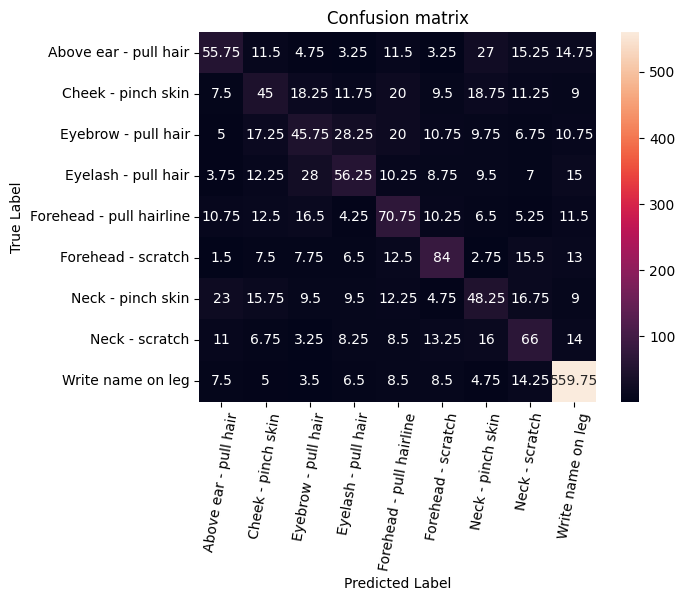

In [68]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
# fold["classification_report"]